<a href="https://colab.research.google.com/github/rubamamehnaj/codemaker/blob/main/codemaker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###`The screenshot of the webpage generated by this project is given in the block below. Please run each of the code block one after other. Please run the last codeblock twice, this would generate a webpage of the form https://*.ngrok-free.app/. Click on it , please a screenshot of an webpage such google.com; and then click generate code to see html , css and js needed to make the webpage. PS the quality of the webpage generated depends on the LLM multimodal vision model used.For example in the experiment at the moment gemma3:4b is being used.`

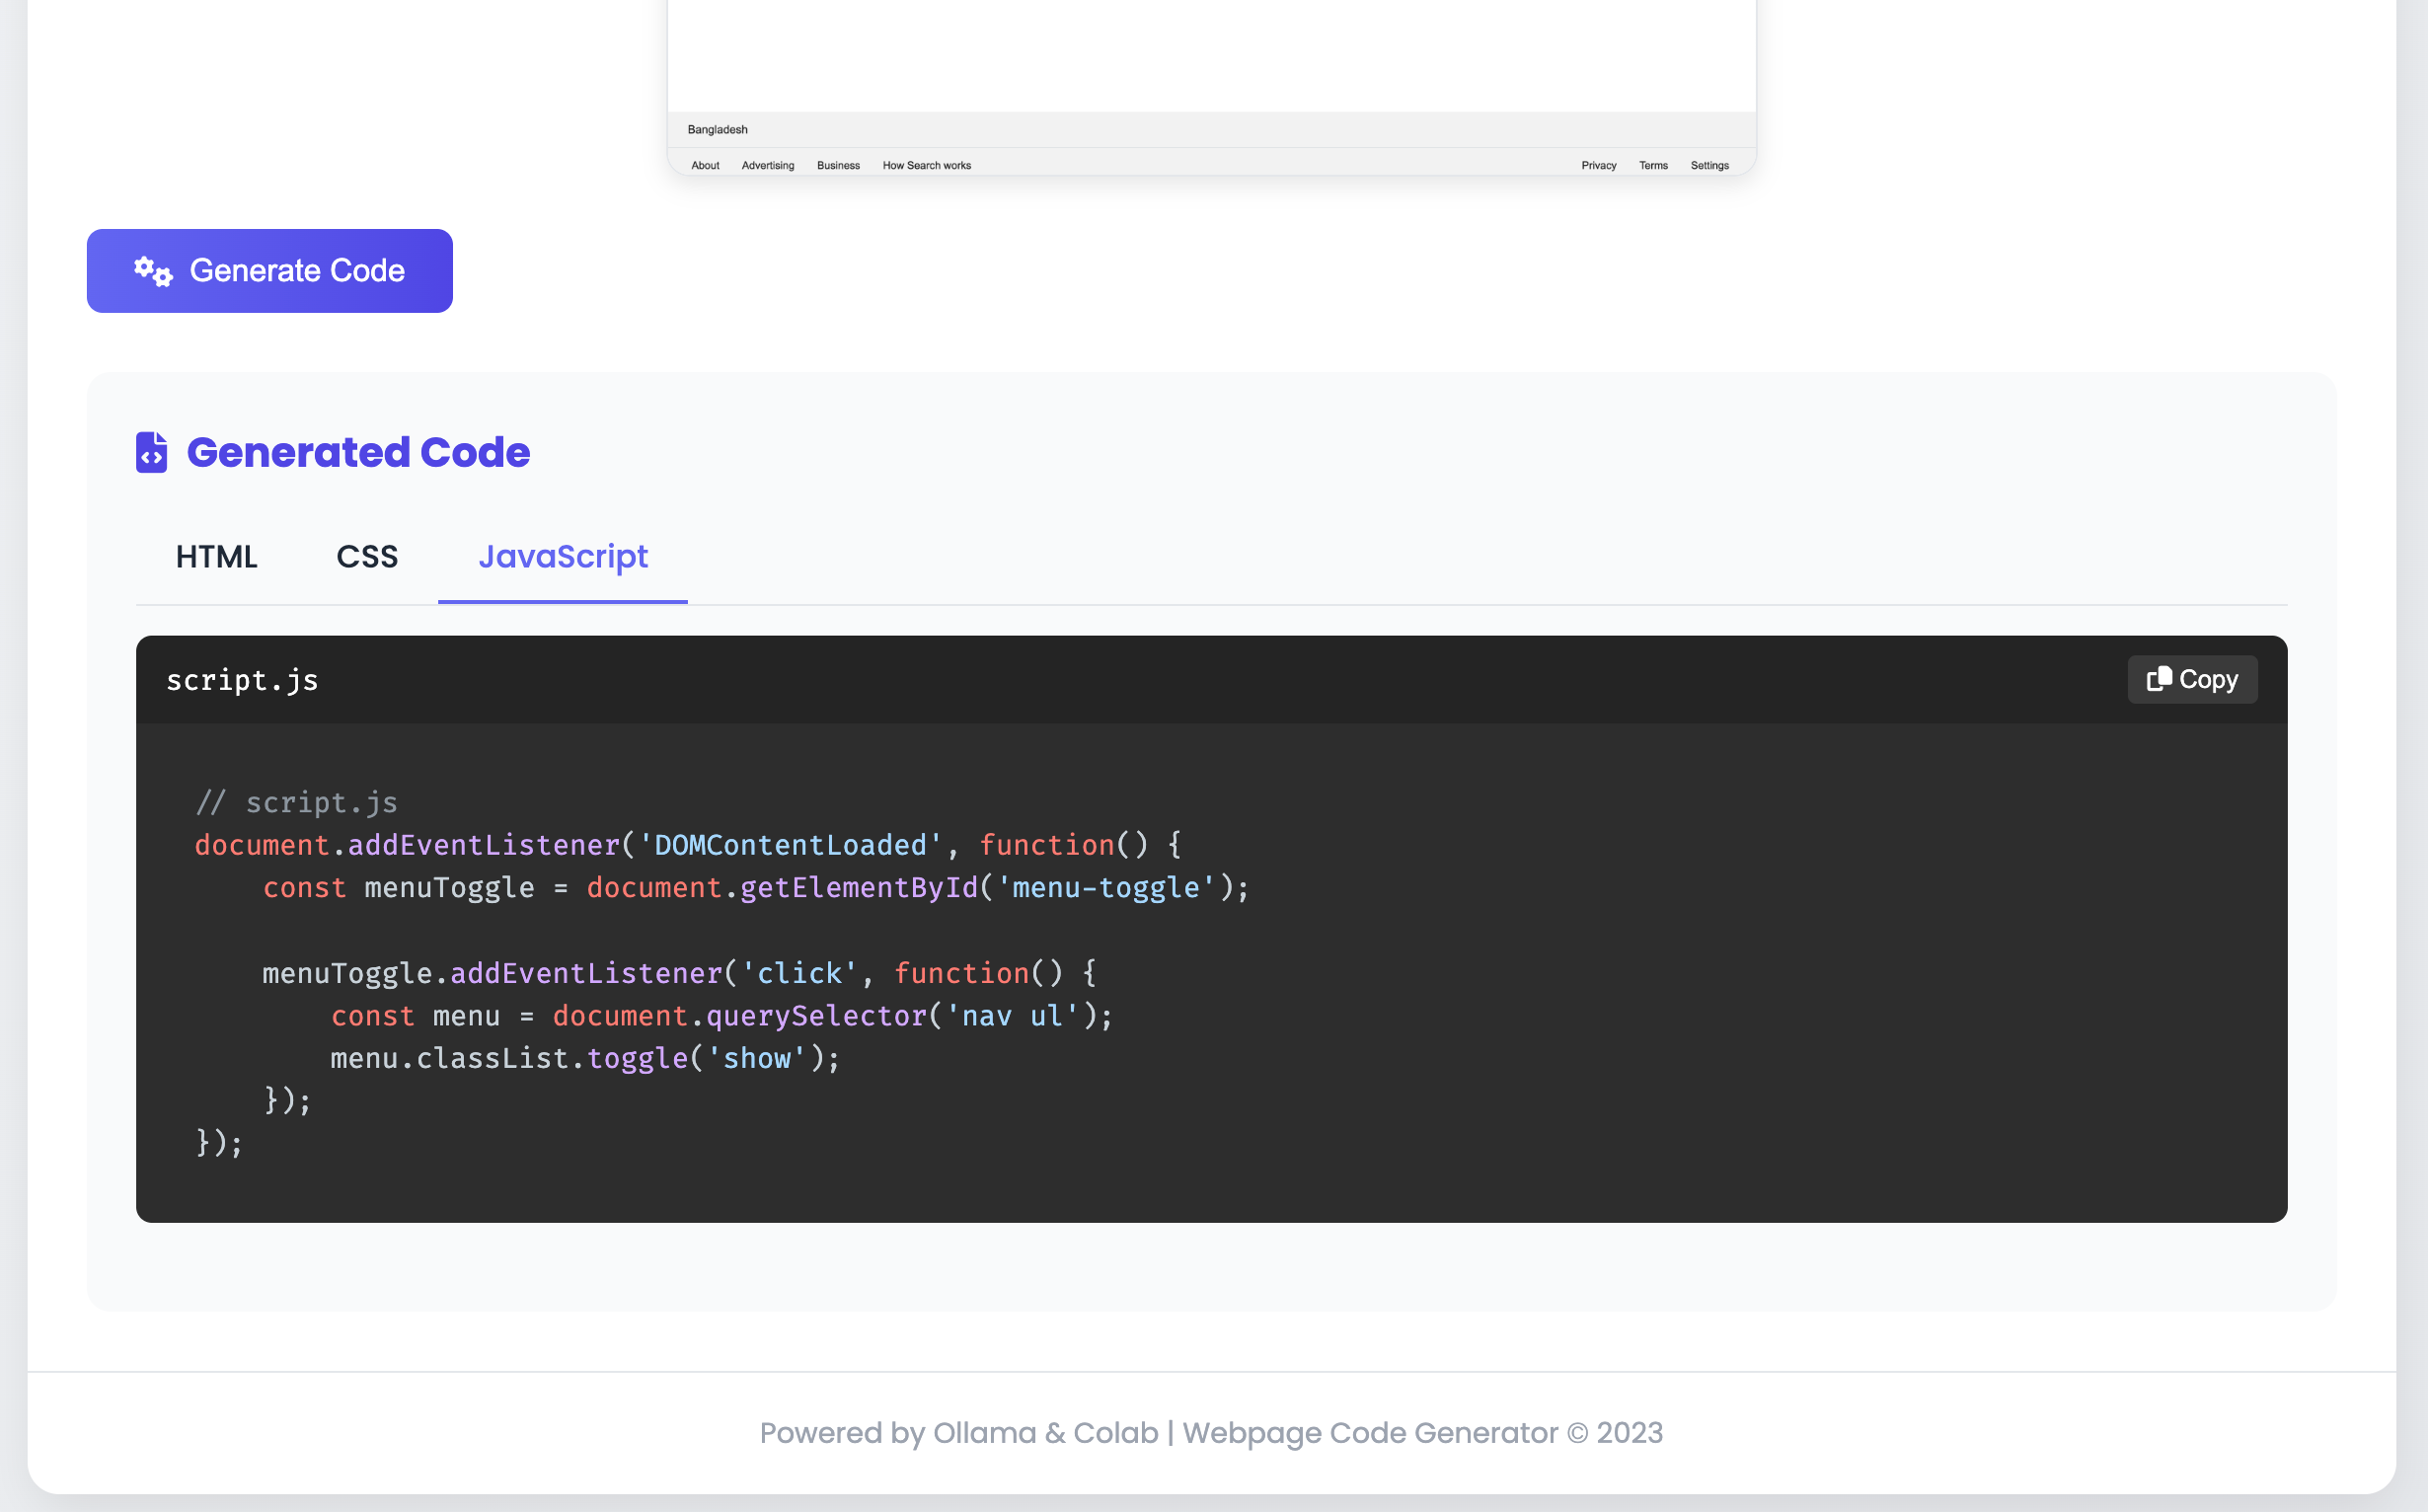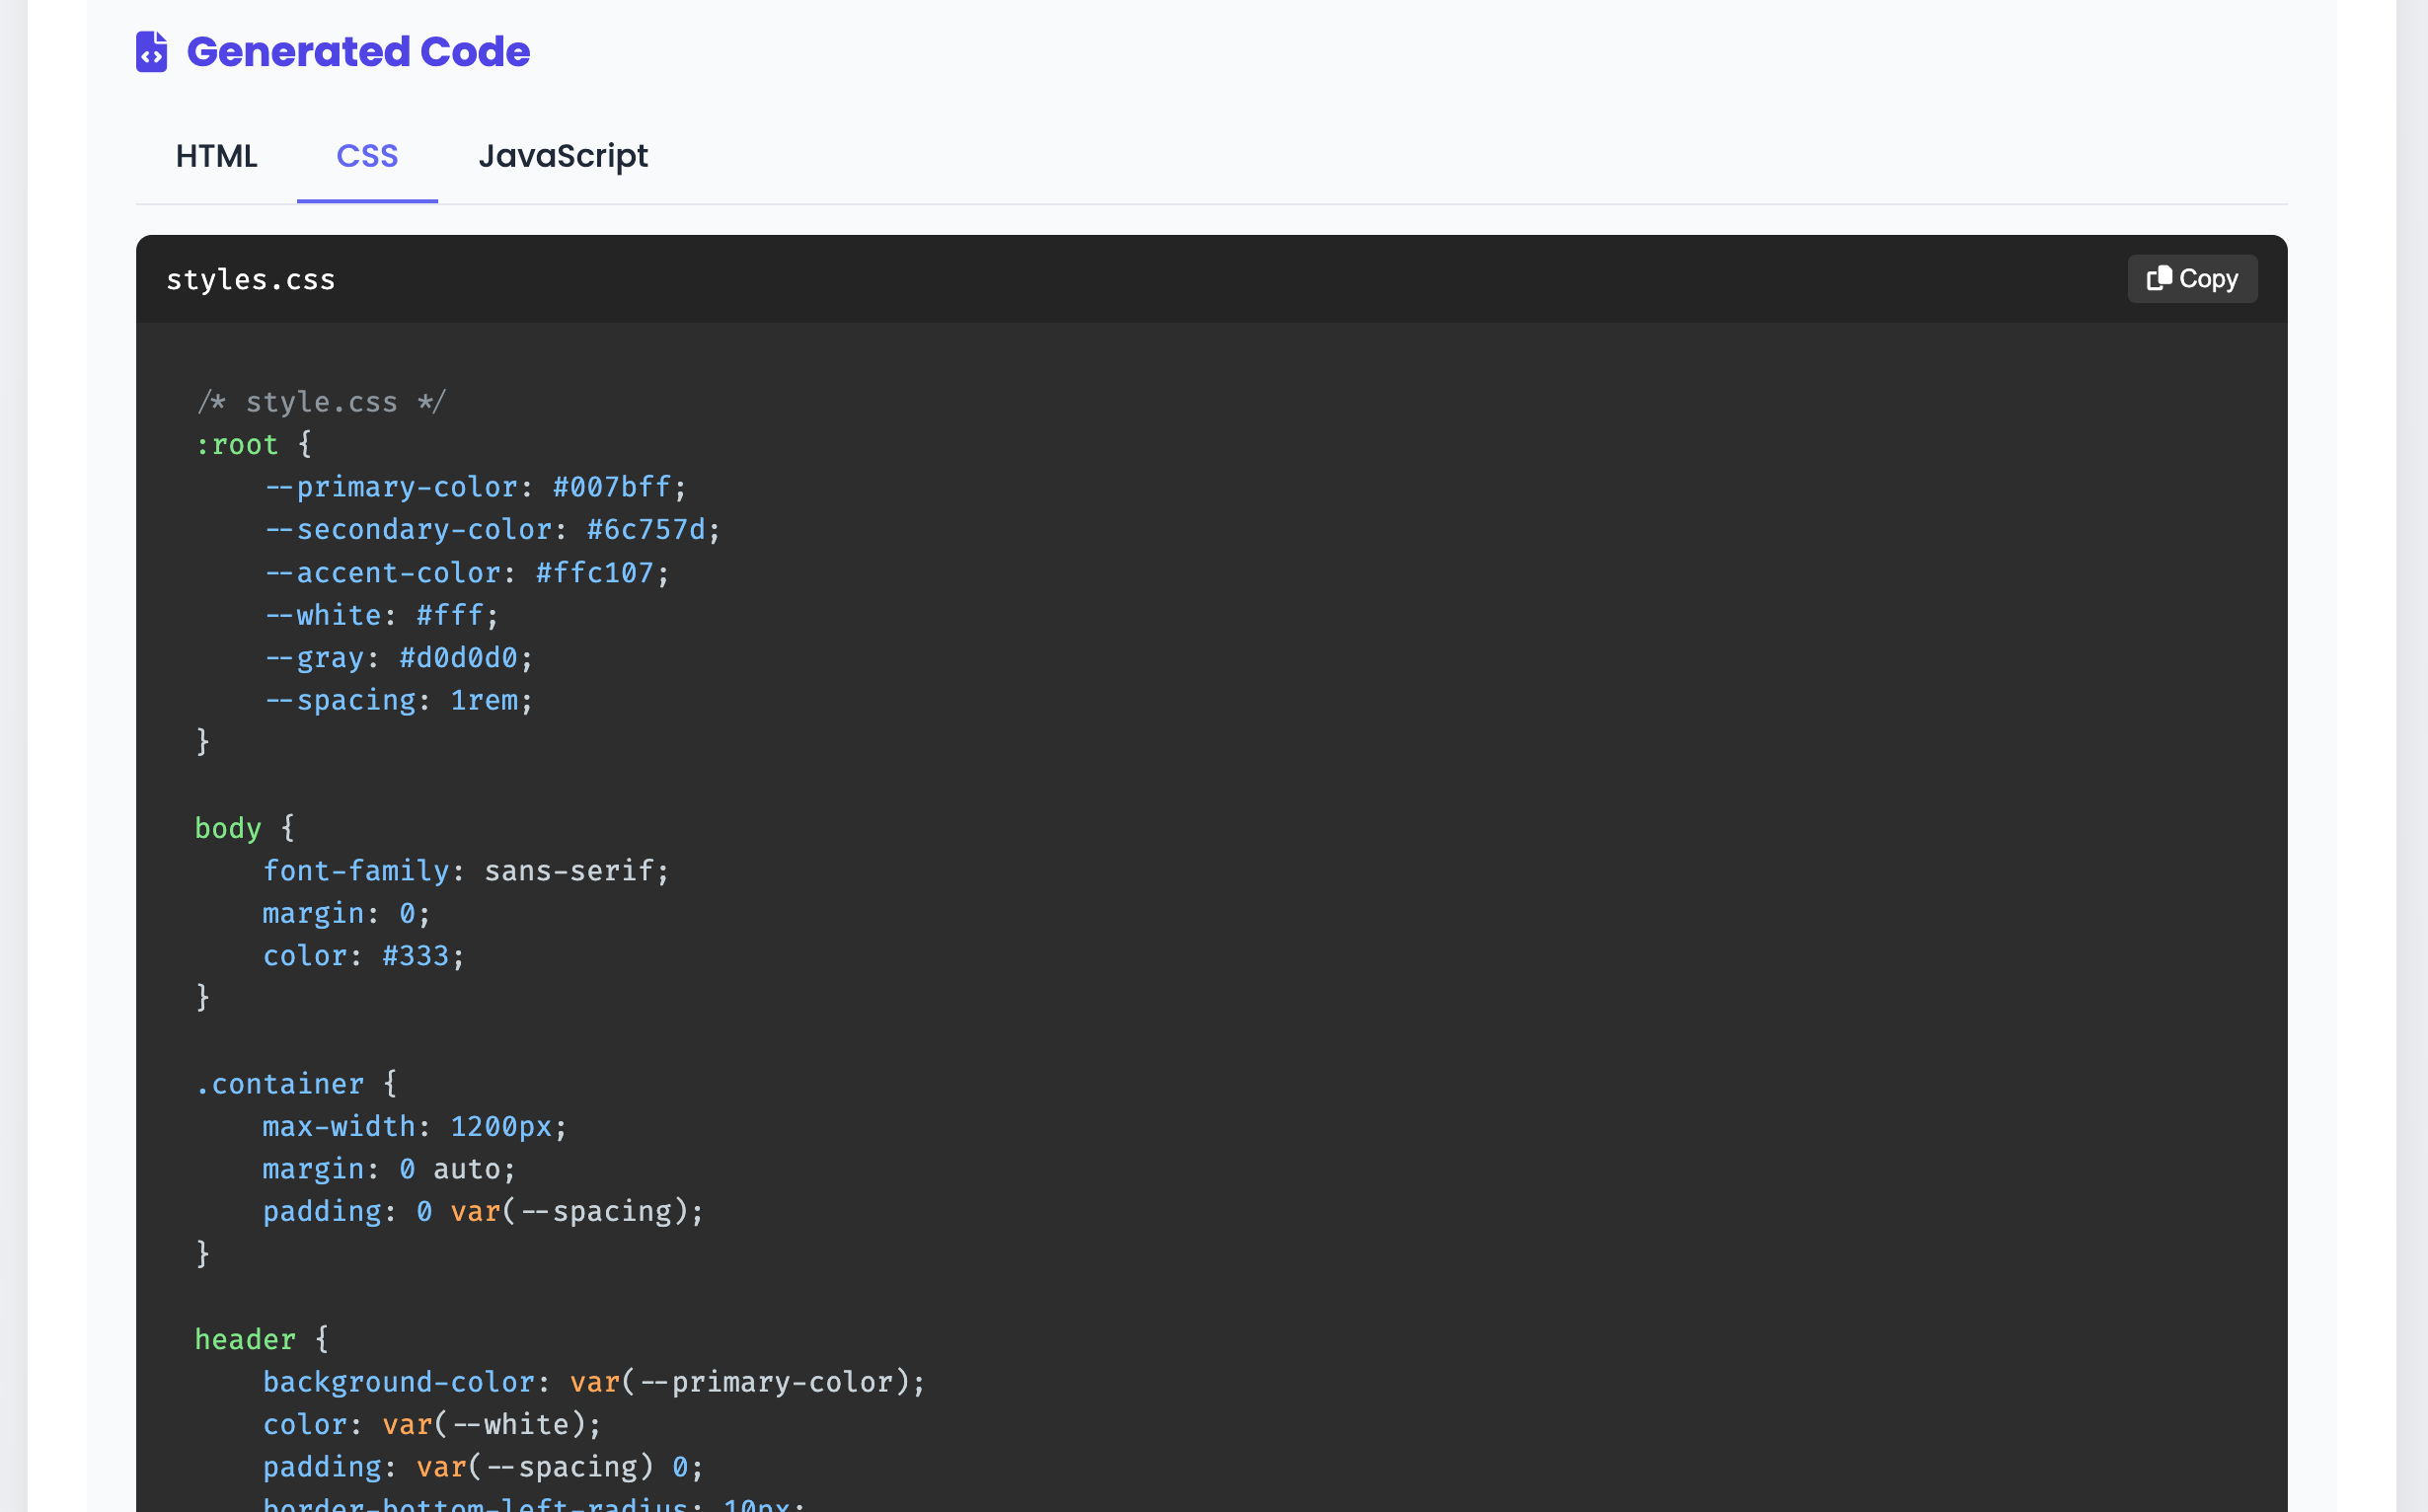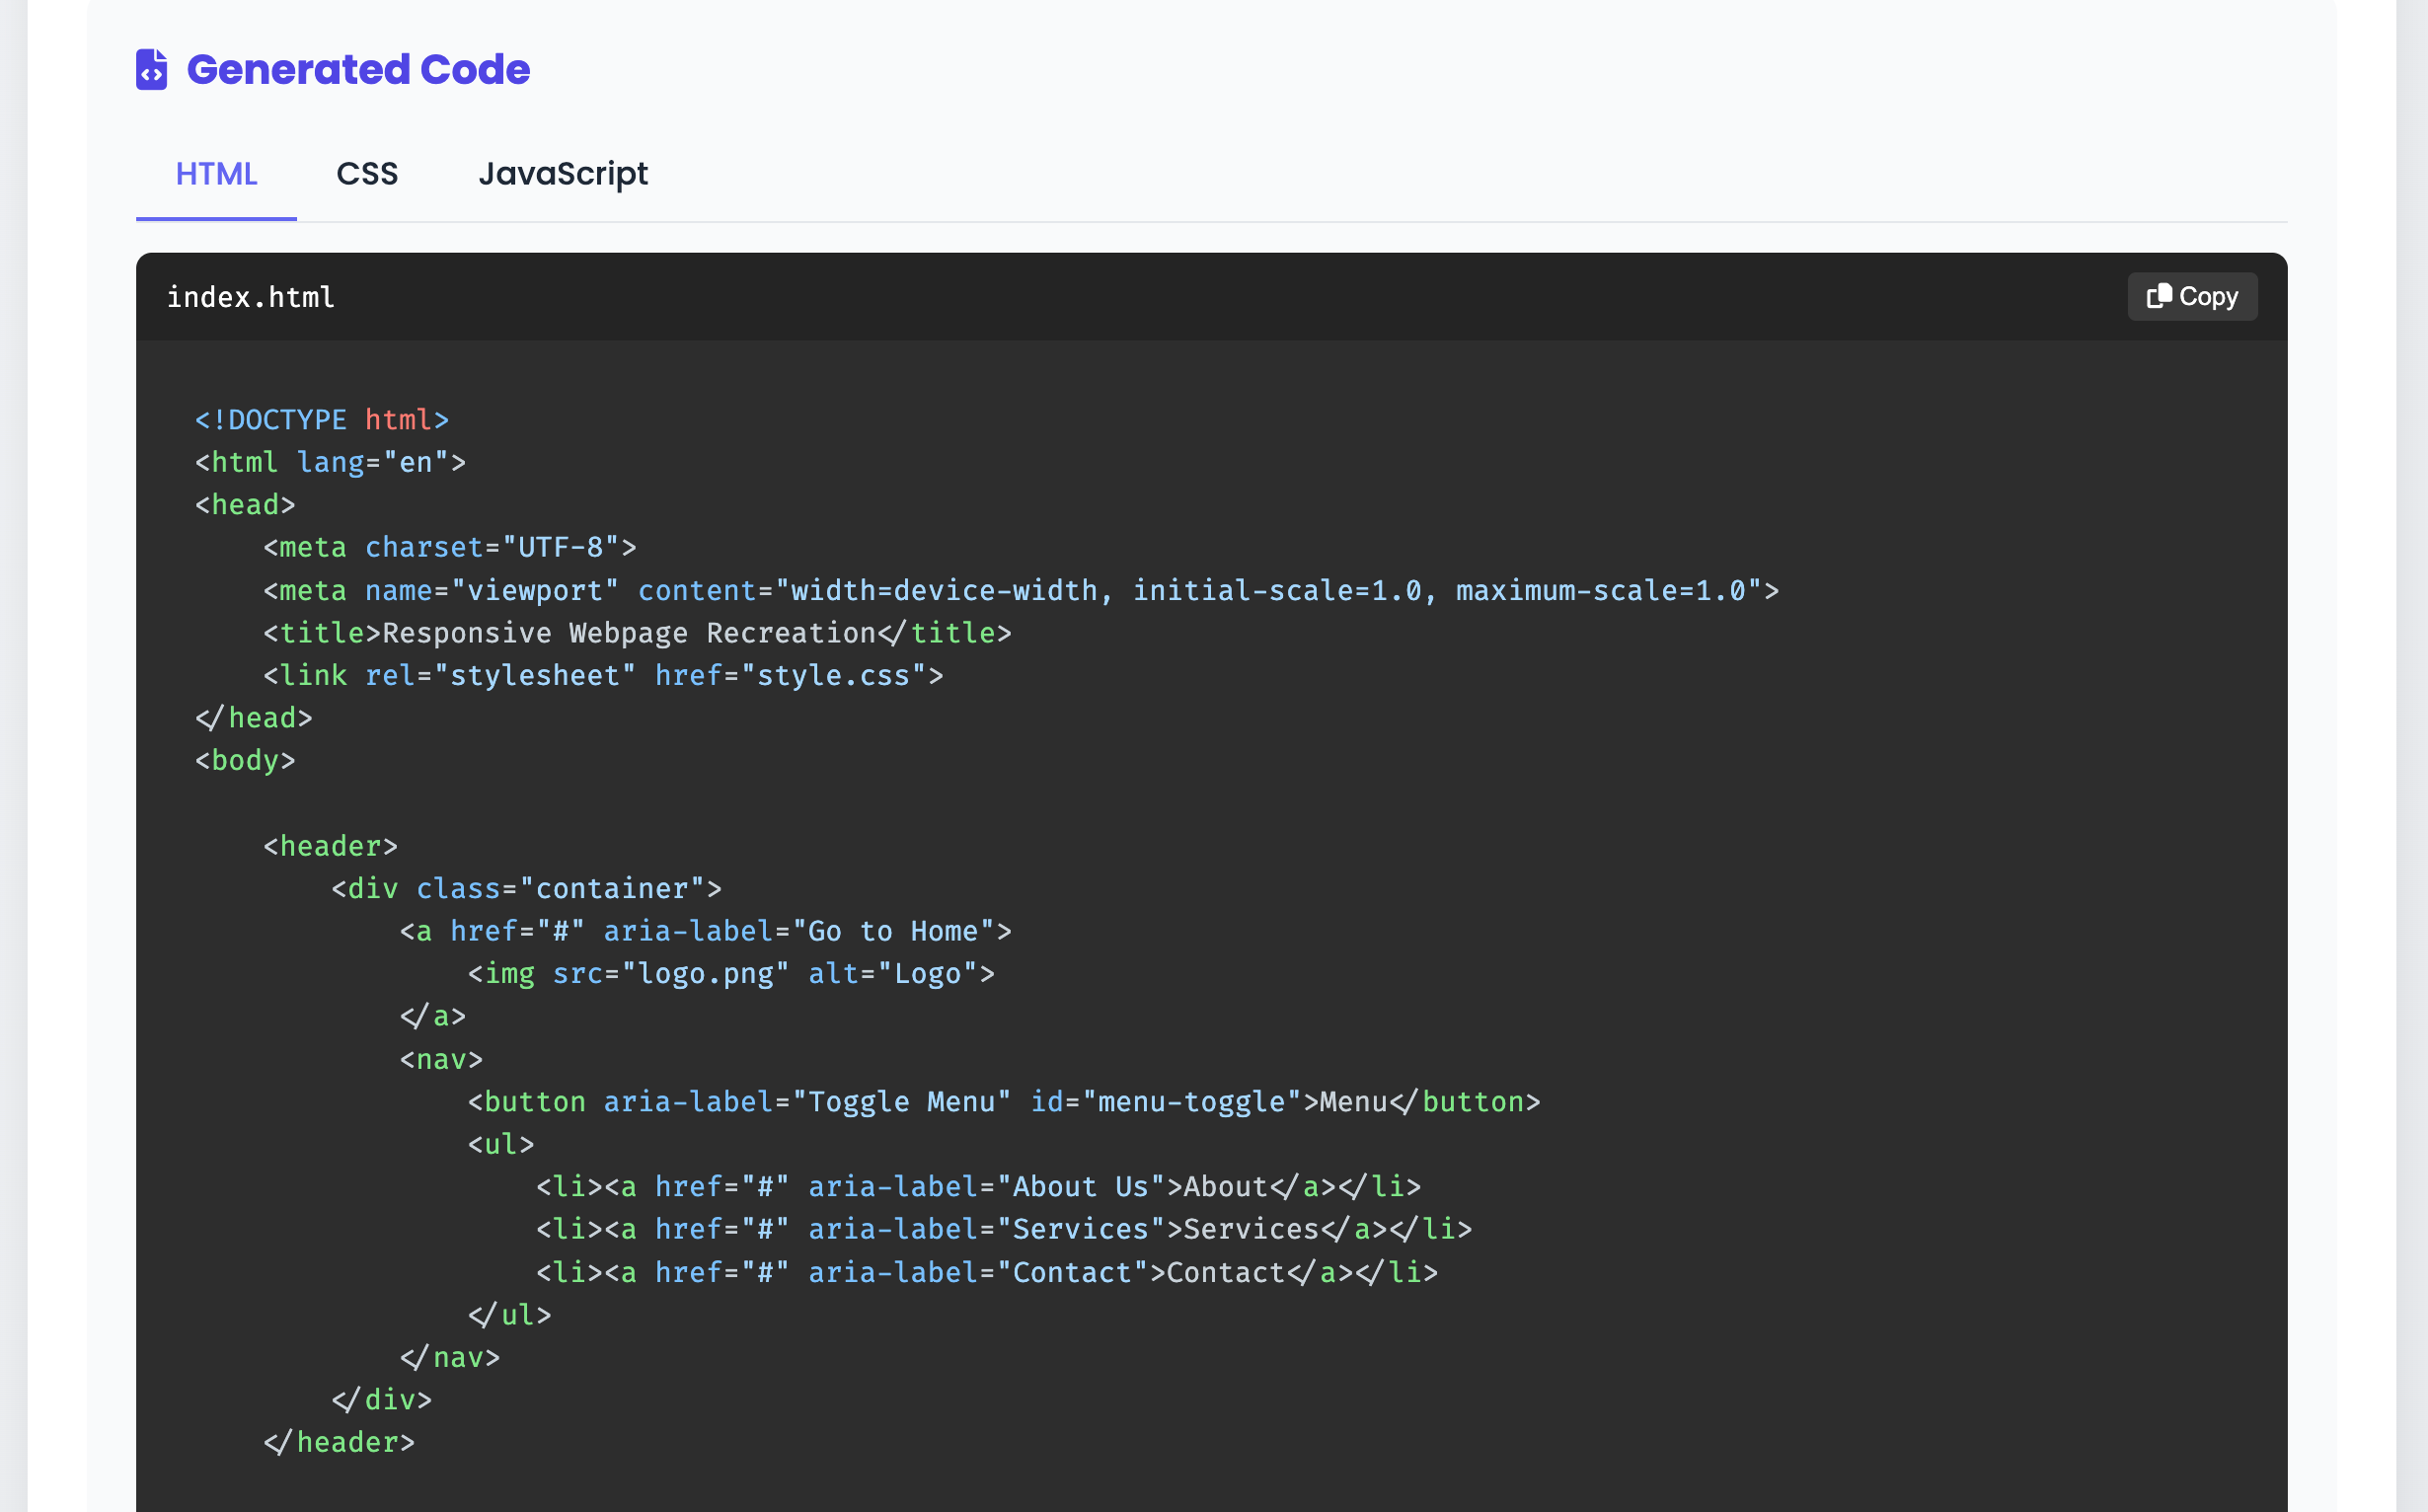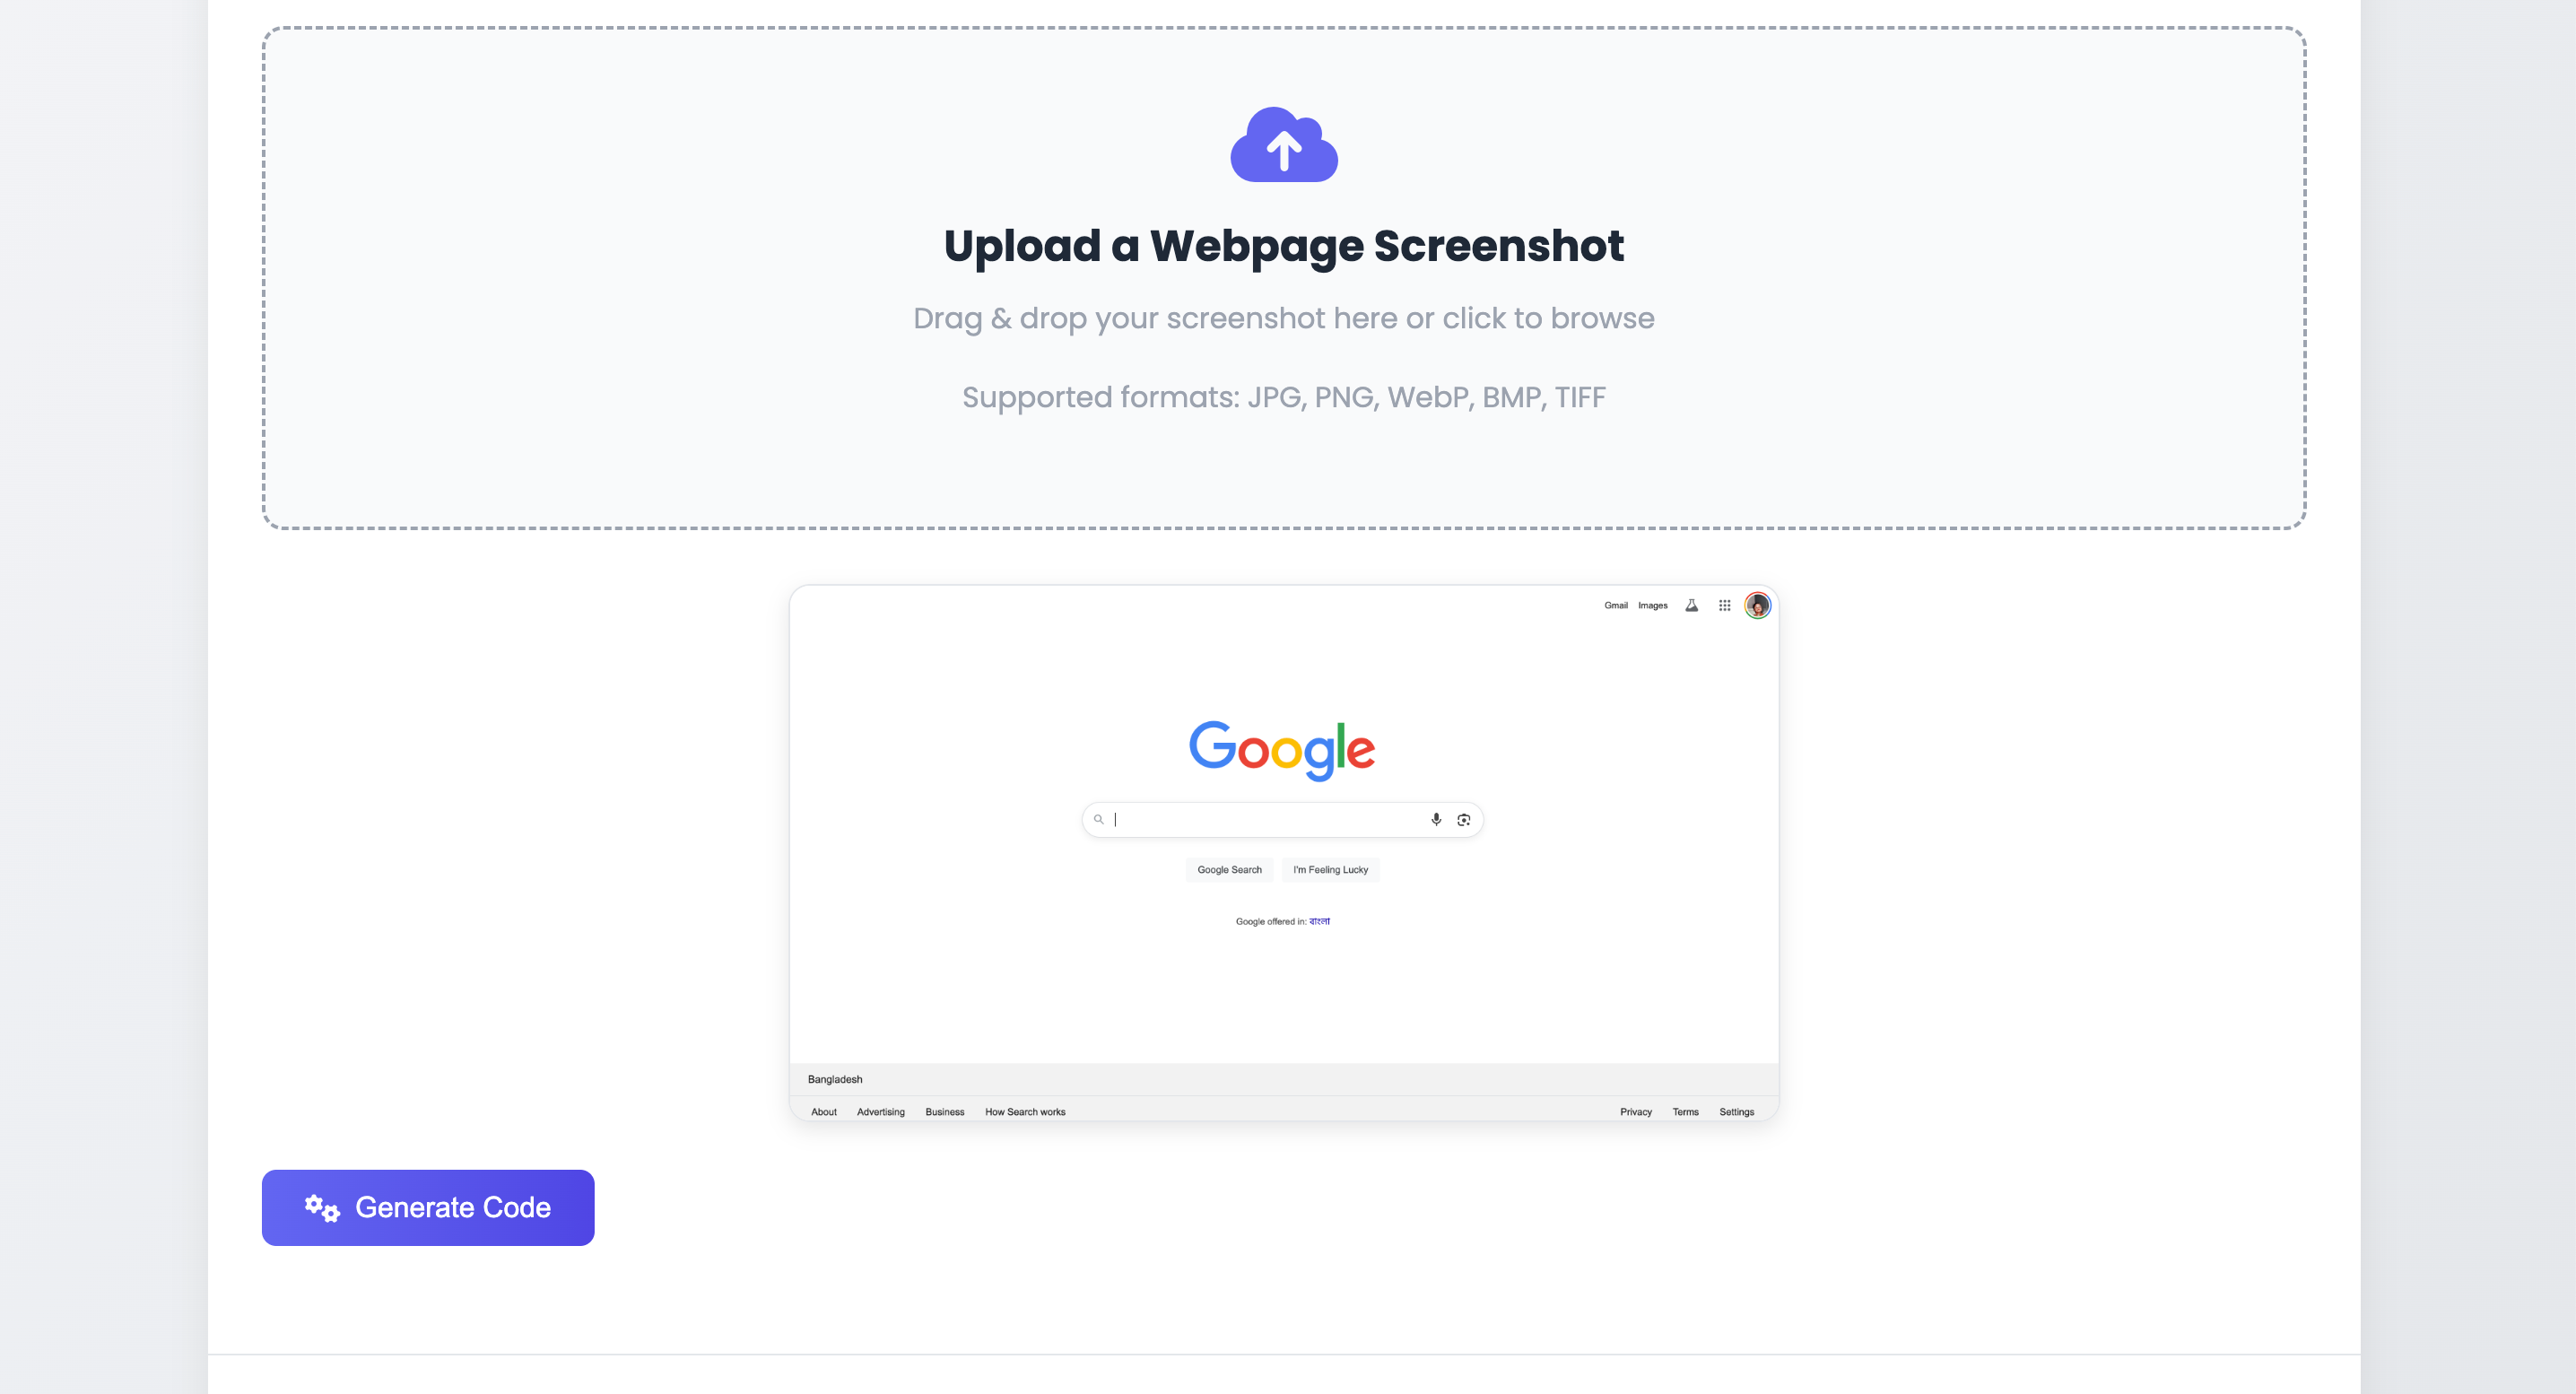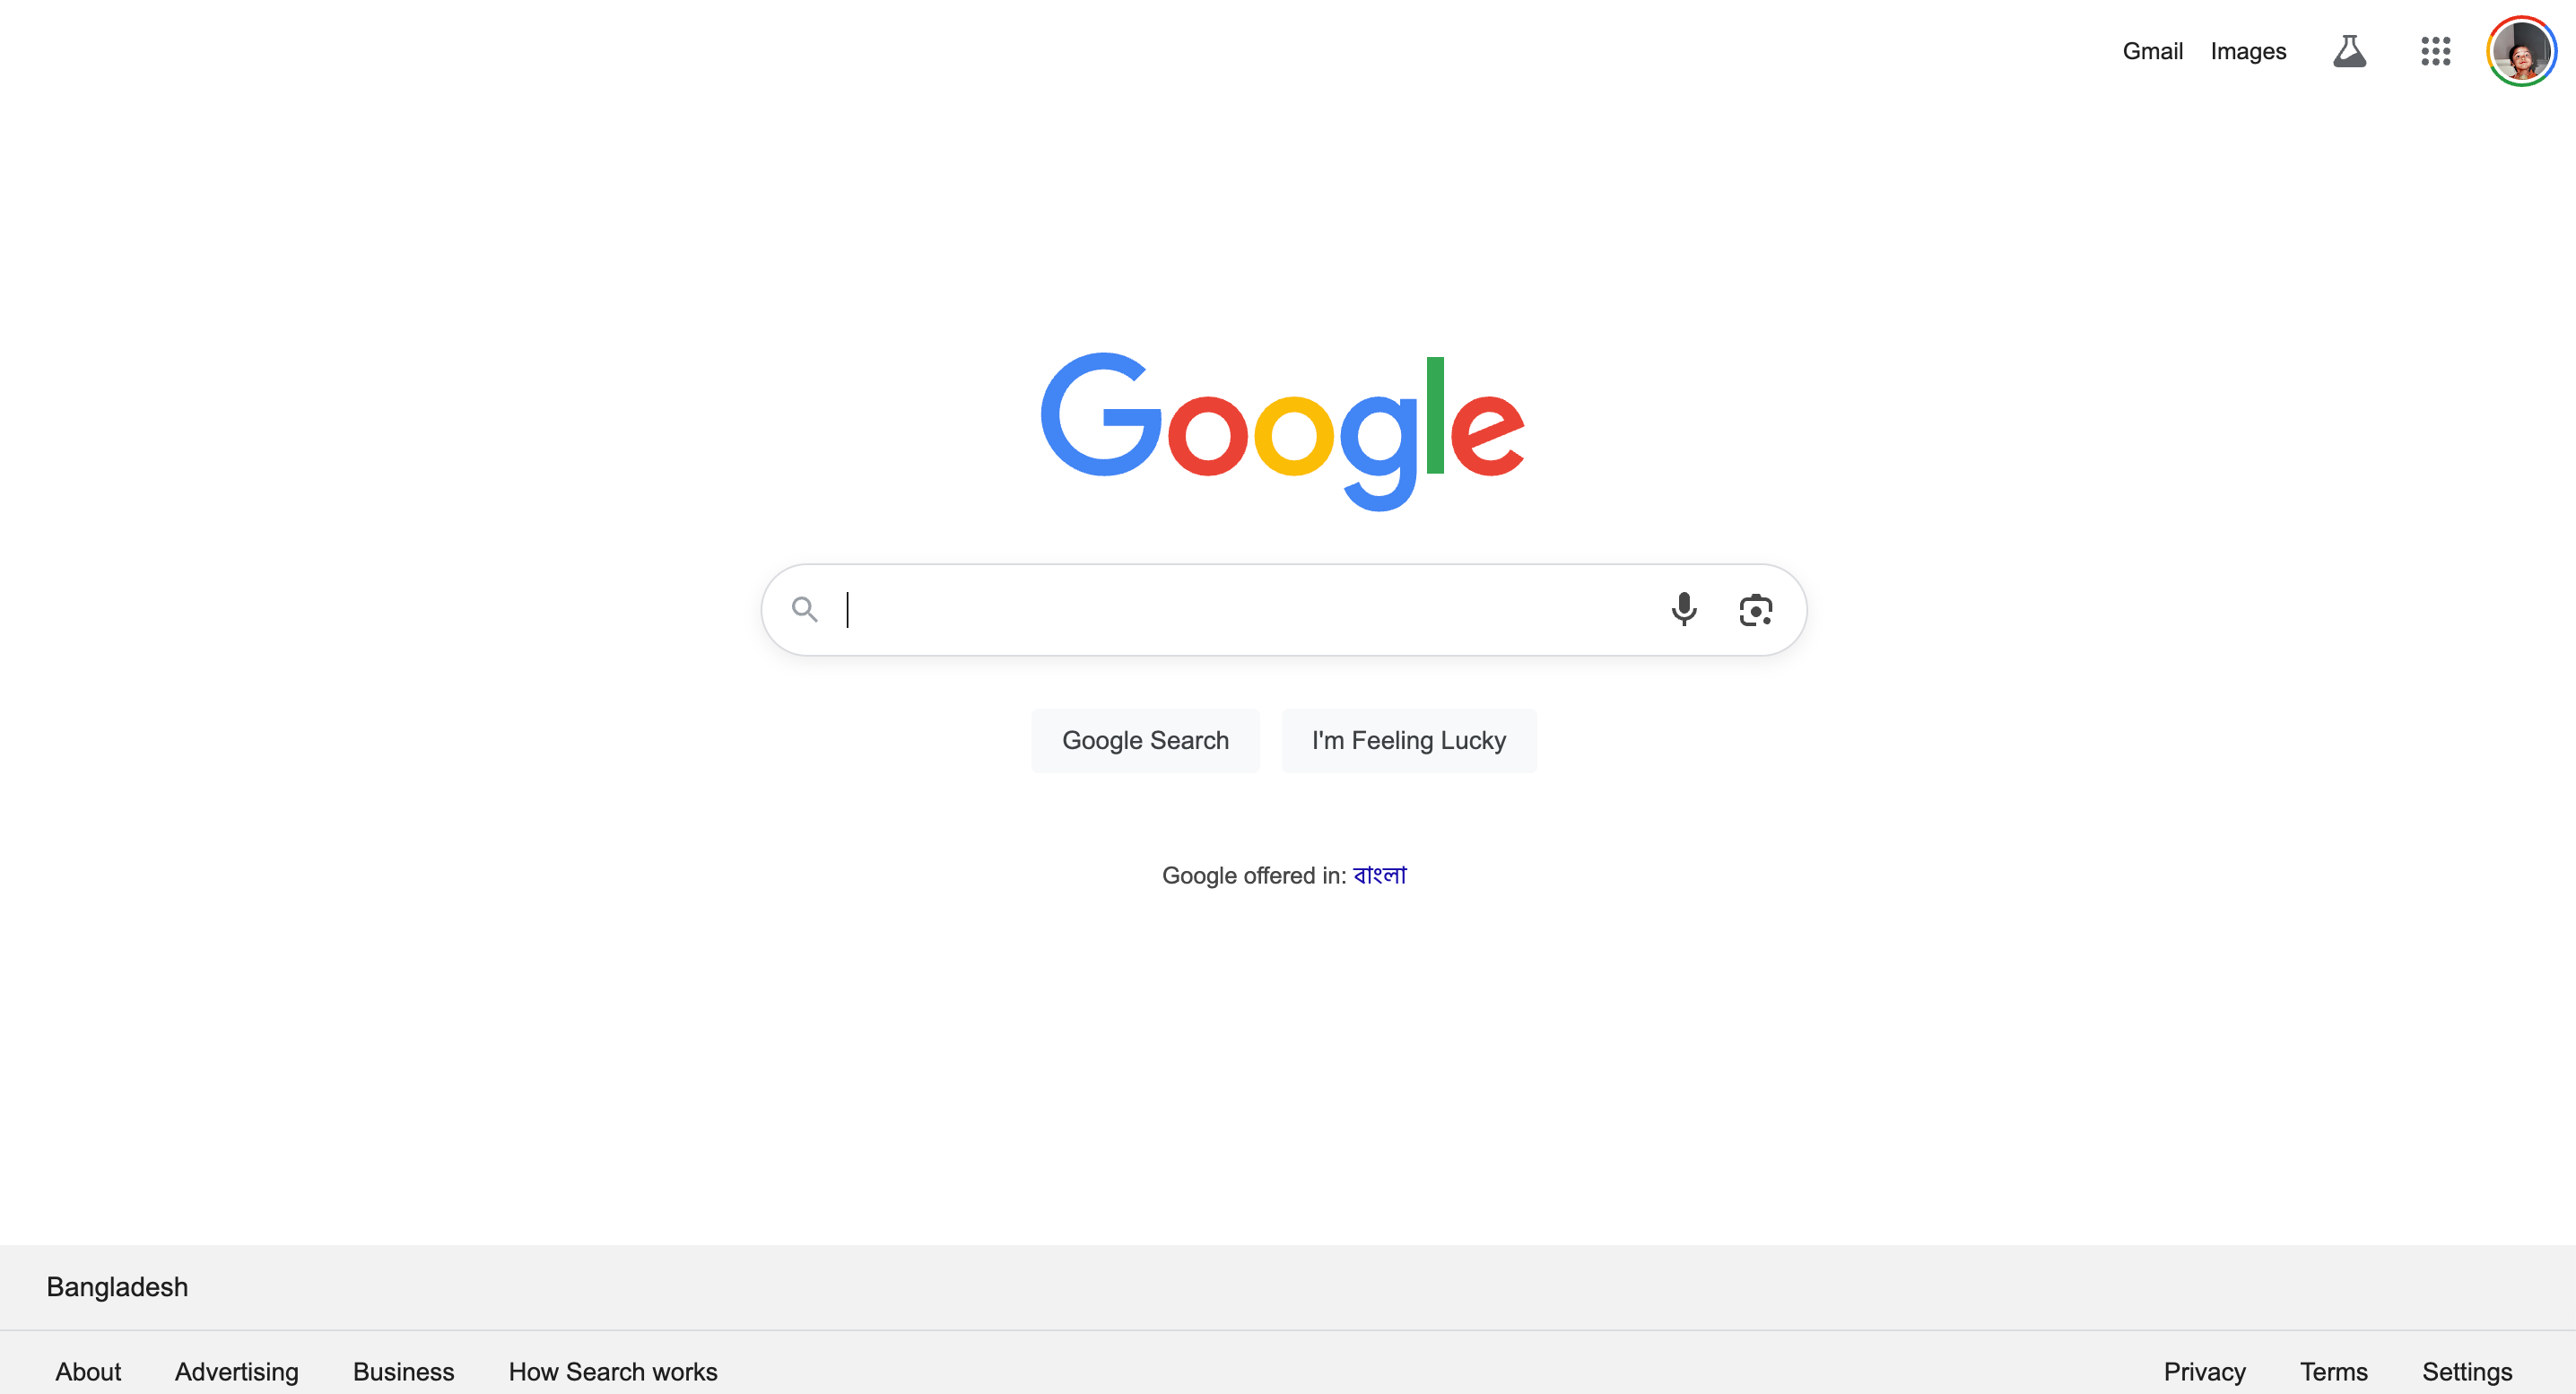

In [ ]:
# 1) Install required packages
!pip install pyngrok

In [ ]:
# 2) Check GPU & set env flags
import os, subprocess, re, textwrap, json, time, base64, requests
from pathlib import Path

# Detect GPU and set Ollama flags
gpu_info = subprocess.run(["nvidia-smi"], capture_output=True, text=True)
if gpu_info.returncode == 0:
    print("✅ NVIDIA GPU detected.")
    os.environ["OLLAMA_USE_NVIDIA"] = "cuda"
else:
    print("⚠️ No GPU detected. Running on CPU.")
    os.environ["OLLAMA_NO_CUDA"] = "1"

✅ NVIDIA GPU detected.


In [ ]:
# 3) Install Ollama (Linux)
!curl -fsSL https://ollama.com/install.sh | sh
!ollama --version

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [ ]:
# 4) Start the Ollama server with proper readiness check
import subprocess, time, os, signal

# Kill any previous Ollama server processes
!pkill -f "ollama serve" || true

server = subprocess.Popen(["ollama", "serve"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# Improved readiness check with timeout
max_wait_time = 30
start_time = time.time()
server_ready = False

while time.time() - start_time < max_wait_time:
    try:
        r = requests.get("http://localhost:11434", timeout=2)
        if r.status_code == 200:
            print("✅ Ollama server is ready.")
            server_ready = True
            break
    except:
        time.sleep(1)

if not server_ready:
    print("❌ Ollama server didn't become ready in time")

^C
✅ Ollama server is ready.


In [ ]:
# 5) Pull a vision model
#MODEL = "llava:7b"   # choices: "moondream", "llava:7b", "llava:13b"
#MODEL = "gemma3:27b" # for better answer
#For more models - https://ollama.com/search?c=vision
MODEL = "gemma3:4b"
!ollama pull {MODEL}

In [ ]:
# 6) Set up Pyngrok to expose Ollama API
from pyngrok import ngrok, conf
import threading

# Set up ngrok authentication (get your auth token from https://dashboard.ngrok.com/auth)
NGROK_AUTH_TOKEN = "30JK4G2fKOHxPGUAu5QOIWdxXks_71eCzwuwuikMMTTk4sR8j"  # Replace with your actual token
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Create a tunnel to the Ollama server
public_url = ngrok.connect(11434, "http")
print(f"✅ Ollama API exposed at: {public_url}")

✅ Ollama API exposed at: NgrokTunnel: "https://8fbf12163770.ngrok-free.app" -> "http://localhost:11434"


In [ ]:
# 7) Create a fancy web interface for webpage screenshot to code generation
#this works
from flask import Flask, request, jsonify, render_template_string
import threading

# Enhanced HTML template with modern styling for code generation
HTML_TEMPLATE = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Webpage Code Generator - Screenshot to HTML/CSS/JS</title>
    <link href="https://fonts.googleapis.com/css2?family=Fira+Code:wght@400;500&family=Poppins:wght@300;400;500;600;700&display=swap" rel="stylesheet">
    <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/6.4.0/css/all.min.css">
    <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/highlight.js/11.8.0/styles/github-dark.min.css">
    <script src="https://cdnjs.cloudflare.com/ajax/libs/highlight.js/11.8.0/highlight.min.js"></script>
    <script src="https://cdnjs.cloudflare.com/ajax/libs/highlight.js/11.8.0/languages/xml.min.js"></script>
    <script src="https://cdnjs.cloudflare.com/ajax/libs/highlight.js/11.8.0/languages/css.min.js"></script>
    <script src="https://cdnjs.cloudflare.com/ajax/libs/highlight.js/11.8.0/languages/javascript.min.js"></script>
    <style>
        :root {
            --primary: #6366f1;
            --primary-dark: #4f46e5;
            --secondary: #10b981;
            --dark: #1f2937;
            --light: #f9fafb;
            --gray: #9ca3af;
            --danger: #ef4444;
            --code-bg: #2d2d2d;
        }

        * {
            margin: 0;
            padding: 0;
            box-sizing: border-box;
        }

        body {
            font-family: 'Poppins', sans-serif;
            background: linear-gradient(135deg, #f3f4f6, #e5e7eb);
            color: var(--dark);
            min-height: 100vh;
            padding: 20px;
        }

        .container {
            max-width: 1200px;
            margin: 0 auto;
            background: white;
            border-radius: 16px;
            box-shadow: 0 10px 25px -5px rgba(0, 0, 0, 0.1);
            overflow: hidden;
        }

        header {
            background: linear-gradient(to right, var(--primary), var(--primary-dark));
            color: white;
            padding: 30px;
            text-align: center;
        }

        header h1 {
            font-size: 2.5rem;
            font-weight: 700;
            margin-bottom: 10px;
        }

        header p {
            font-size: 1.1rem;
            opacity: 0.9;
        }

        .main-content {
            padding: 30px;
        }

        .upload-section {
            margin-bottom: 30px;
        }

        .upload-area {
            border: 2px dashed var(--gray);
            border-radius: 12px;
            padding: 40px;
            text-align: center;
            transition: all 0.3s ease;
            background: var(--light);
            cursor: pointer;
            position: relative;
        }

        .upload-area:hover, .upload-area.dragover {
            border-color: var(--primary);
            background: rgba(99, 102, 241, 0.05);
        }

        .upload-area i {
            font-size: 3rem;
            color: var(--primary);
            margin-bottom: 15px;
        }

        .upload-area h3 {
            font-size: 1.5rem;
            margin-bottom: 10px;
            color: var(--dark);
        }

        .upload-area p {
            color: var(--gray);
            margin-bottom: 20px;
        }

        .file-input {
            position: absolute;
            width: 100%;
            height: 100%;
            top: 0;
            left: 0;
            opacity: 0;
            cursor: pointer;
        }

        .btn {
            background: linear-gradient(to right, var(--primary), var(--primary-dark));
            color: white;
            border: none;
            padding: 12px 24px;
            border-radius: 8px;
            font-size: 1rem;
            font-weight: 500;
            cursor: pointer;
            transition: all 0.3s ease;
            display: inline-flex;
            align-items: center;
            justify-content: center;
        }

        .btn:hover {
            transform: translateY(-2px);
            box-shadow: 0 4px 12px rgba(99, 102, 241, 0.3);
        }

        .btn:disabled {
            background: var(--gray);
            cursor: not-allowed;
            transform: none;
            box-shadow: none;
        }

        .btn i {
            margin-right: 8px;
        }

        .image-preview {
            margin-top: 30px;
            text-align: center;
            display: none;
        }

        .image-preview img {
            max-width: 100%;
            max-height: 300px;
            border-radius: 12px;
            box-shadow: 0 4px 12px rgba(0, 0, 0, 0.1);
            border: 1px solid #e5e7eb;
        }

        .result-section {
            background: var(--light);
            border-radius: 12px;
            padding: 25px;
            margin-top: 30px;
            display: none;
        }

        .result-section h3 {
            font-size: 1.3rem;
            margin-bottom: 15px;
            color: var(--primary-dark);
            display: flex;
            align-items: center;
        }

        .result-section h3 i {
            margin-right: 10px;
        }

        .code-tabs {
            display: flex;
            border-bottom: 1px solid #e5e7eb;
            margin-bottom: 15px;
        }

        .code-tab {
            padding: 10px 20px;
            cursor: pointer;
            border-bottom: 2px solid transparent;
            font-weight: 500;
            transition: all 0.3s ease;
        }

        .code-tab.active {
            border-bottom: 2px solid var(--primary);
            color: var(--primary);
        }

        .code-content {
            display: none;
        }

        .code-content.active {
            display: block;
        }

        .code-block {
            background: var(--code-bg);
            border-radius: 8px;
            padding: 0;
            overflow: hidden;
            margin-bottom: 20px;
        }

        .code-header {
            background: rgba(0, 0, 0, 0.2);
            padding: 10px 15px;
            display: flex;
            justify-content: space-between;
            align-items: center;
            color: white;
            font-family: 'Fira Code', monospace;
            font-size: 0.9rem;
        }

        .copy-btn {
            background: rgba(255, 255, 255, 0.1);
            color: white;
            border: none;
            padding: 5px 10px;
            border-radius: 4px;
            cursor: pointer;
            font-size: 0.8rem;
            transition: all 0.3s ease;
        }

        .copy-btn:hover {
            background: rgba(255, 255, 255, 0.2);
        }

        pre {
            margin: 0;
            padding: 15px;
            overflow-x: auto;
        }

        code {
            font-family: 'Fira Code', monospace;
            font-size: 0.9rem;
            line-height: 1.5;
        }

        .hljs {
            background: transparent;
            padding: 0;
        }

        .loading {
            display: none;
            text-align: center;
            margin: 20px 0;
        }

        .spinner {
            width: 40px;
            height: 40px;
            border: 4px solid rgba(99, 102, 241, 0.3);
            border-radius: 50%;
            border-top-color: var(--primary);
            animation: spin 1s ease-in-out infinite;
            margin: 0 auto 15px;
        }

        @keyframes spin {
            to { transform: rotate(360deg); }
        }

        .error {
            background: #fee2e2;
            color: var(--danger);
            padding: 15px;
            border-radius: 8px;
            margin-top: 20px;
            display: none;
            border-left: 4px solid var(--danger);
        }

        footer {
            text-align: center;
            padding: 20px;
            color: var(--gray);
            font-size: 0.9rem;
            border-top: 1px solid #e5e7eb;
        }

        @media (max-width: 768px) {
            header h1 {
                font-size: 2rem;
            }

            .main-content {
                padding: 20px;
            }

            .upload-area {
                padding: 30px 20px;
            }

            .code-tabs {
                flex-direction: column;
            }

            .code-tab {
                border-bottom: 1px solid #e5e7eb;
            }
        }
    </style>
</head>
<body>
    <div class="container">
        <header>
            <h1><i class="fas fa-code"></i> Webpage Code Generator</h1>
            <p>Convert webpage screenshots to HTML, CSS, and JavaScript code</p>
        </header>

        <div class="main-content">
            <div class="upload-section">
                <div class="upload-area" id="uploadArea">
                    <i class="fas fa-cloud-upload-alt"></i>
                    <h3>Upload a Webpage Screenshot</h3>
                    <p>Drag & drop your screenshot here or click to browse</p>
                    <p class="small">Supported formats: JPG, PNG, WebP, BMP, TIFF</p>
                    <input type="file" id="imageFile" class="file-input" accept="image/*" required>
                </div>

                <div class="image-preview" id="imagePreview">
                    <img id="previewImg" src="" alt="Preview">
                </div>

                <div class="text-center" style="margin-top: 20px;">
                    <button id="generateBtn" class="btn" disabled>
                        <i class="fas fa-cogs"></i> Generate Code
                    </button>
                </div>

                <div class="loading" id="loading">
                    <div class="spinner"></div>
                    <p>Analyzing your screenshot and generating code... This may take a moment</p>
                </div>

                <div class="error" id="error"></div>
            </div>

            <div class="result-section" id="resultSection">
                <h3><i class="fas fa-file-code"></i> Generated Code</h3>

                <div class="code-tabs" id="codeTabs">
                    <div class="code-tab active" data-tab="html">HTML</div>
                    <div class="code-tab" data-tab="css">CSS</div>
                    <div class="code-tab" data-tab="js">JavaScript</div>
                </div>

                <div class="code-content active" id="htmlContent">
                    <div class="code-block">
                        <div class="code-header">
                            <span>index.html</span>
                            <button class="copy-btn" data-code="htmlCode">
                                <i class="fas fa-copy"></i> Copy
                            </button>
                        </div>
                        <pre><code class="language-html" id="htmlCode"></code></pre>
                    </div>
                </div>

                <div class="code-content" id="cssContent">
                    <div class="code-block">
                        <div class="code-header">
                            <span>styles.css</span>
                            <button class="copy-btn" data-code="cssCode">
                                <i class="fas fa-copy"></i> Copy
                            </button>
                        </div>
                        <pre><code class="language-css" id="cssCode"></code></pre>
                    </div>
                </div>

                <div class="code-content" id="jsContent">
                    <div class="code-block">
                        <div class="code-header">
                            <span>script.js</span>
                            <button class="copy-btn" data-code="jsCode">
                                <i class="fas fa-copy"></i> Copy
                            </button>
                        </div>
                        <pre><code class="language-javascript" id="jsCode"></code></pre>
                    </div>
                </div>
            </div>
        </div>

        <footer>
            <p>Powered by Ollama & Colab | Webpage Code Generator © 2023</p>
        </footer>
    </div>

    <script>
        document.addEventListener('DOMContentLoaded', function() {
            const uploadArea = document.getElementById('uploadArea');
            const fileInput = document.getElementById('imageFile');
            const previewImg = document.getElementById('previewImg');
            const imagePreview = document.getElementById('imagePreview');
            const generateBtn = document.getElementById('generateBtn');
            const loading = document.getElementById('loading');
            const resultSection = document.getElementById('resultSection');
            const errorDiv = document.getElementById('error');
            const codeTabs = document.getElementById('codeTabs');
            const htmlCode = document.getElementById('htmlCode');
            const cssCode = document.getElementById('cssCode');
            const jsCode = document.getElementById('jsCode');

            // Initialize syntax highlighting
            hljs.highlightAll();

            // Handle drag and drop events
            ['dragenter', 'dragover', 'dragleave', 'drop'].forEach(eventName => {
                uploadArea.addEventListener(eventName, preventDefaults, false);
            });

            function preventDefaults(e) {
                e.preventDefault();
                e.stopPropagation();
            }

            ['dragenter', 'dragover'].forEach(eventName => {
                uploadArea.addEventListener(eventName, highlight, false);
            });

            ['dragleave', 'drop'].forEach(eventName => {
                uploadArea.addEventListener(eventName, unhighlight, false);
            });

            function highlight() {
                uploadArea.classList.add('dragover');
            }

            function unhighlight() {
                uploadArea.classList.remove('dragover');
            }

            uploadArea.addEventListener('drop', handleDrop, false);

            function handleDrop(e) {
                const dt = e.dataTransfer;
                const files = dt.files;

                if (files.length) {
                    fileInput.files = files;
                    handleFile(files[0]);
                }
            }

            fileInput.addEventListener('change', function() {
                if (this.files && this.files[0]) {
                    handleFile(this.files[0]);
                }
            });

            function handleFile(file) {
                // Validate file type
                const validTypes = ['image/jpeg', 'image/png', 'image/webp', 'image/bmp', 'image/tiff'];
                if (!validTypes.includes(file.type)) {
                    showError('Please select a valid image file (JPG, PNG, WebP, BMP, or TIFF)');
                    return;
                }

                // Clear any previous errors
                hideError();

                // Show preview
                const reader = new FileReader();
                reader.onload = function(e) {
                    previewImg.src = e.target.result;
                    imagePreview.style.display = 'block';
                    generateBtn.disabled = false;
                };
                reader.readAsDataURL(file);
            }

            // Tab switching functionality
            codeTabs.addEventListener('click', function(e) {
                if (e.target.classList.contains('code-tab')) {
                    // Remove active class from all tabs
                    document.querySelectorAll('.code-tab').forEach(tab => {
                        tab.classList.remove('active');
                    });

                    // Hide all content
                    document.querySelectorAll('.code-content').forEach(content => {
                        content.classList.remove('active');
                    });

                    // Add active class to clicked tab
                    e.target.classList.add('active');

                    // Show corresponding content
                    const tabName = e.target.getAttribute('data-tab');
                    document.getElementById(tabName + 'Content').classList.add('active');
                }
            });

            // Copy button functionality
            document.addEventListener('click', function(e) {
                if (e.target.classList.contains('copy-btn') || e.target.closest('.copy-btn')) {
                    const button = e.target.classList.contains('copy-btn') ? e.target : e.target.closest('.copy-btn');
                    const codeId = button.getAttribute('data-code');
                    const codeElement = document.getElementById(codeId);

                    navigator.clipboard.writeText(codeElement.textContent)
                        .then(() => {
                            const originalText = button.innerHTML;
                            button.innerHTML = '<i class="fas fa-check"></i> Copied!';

                            setTimeout(() => {
                                button.innerHTML = originalText;
                            }, 2000);
                        })
                        .catch(err => {
                            console.error('Failed to copy: ', err);
                        });
                }
            });

            generateBtn.addEventListener('click', async function() {
                const file = fileInput.files[0];
                if (!file) return;

                // Show loading, hide results
                loading.style.display = 'block';
                resultSection.style.display = 'none';
                hideError();
                generateBtn.disabled = true;

                const formData = new FormData();
                formData.append('image', file);

                try {
                    const response = await fetch('/describe', {
                        method: 'POST',
                        body: formData
                    });

                    const data = await response.json();

                    if (data.success) {
                        // Parse the response to extract HTML, CSS, and JS
                        parseCodeResponse(data.description);
                        resultSection.style.display = 'block';
                    } else {
                        showError(data.error || 'An error occurred while processing your screenshot');
                    }
                } catch (error) {
                    showError('Network error: ' + error.message);
                } finally {
                    loading.style.display = 'none';
                    generateBtn.disabled = false;
                }
            });

            function parseCodeResponse(response) {
                // Try to extract code from the response
                // This is a simple parser that looks for code blocks
                // A more sophisticated approach would be needed for complex responses

                // Look for HTML code
                const htmlMatch = response.match(/```html\\n([\\s\\S]*?)\\n```/) ||
                                 response.match(/<html[\\s\\S]*?<\\/html>/i) ||
                                 response.match(/<body[\\s\\S]*?<\\/body>/i);

                if (htmlMatch) {
                    htmlCode.textContent = htmlMatch[1] || htmlMatch[0];
                } else {
                    htmlCode.textContent = "// No HTML code found in the response";
                }

                // Look for CSS code
                const cssMatch = response.match(/```css\\n([\\s\\S]*?)\\n```/) ||
                                response.match(/<style[\\s\\S]*?<\\/style>/i) ||
                                response.match(/{[\\s\\S]*?}/);

                if (cssMatch) {
                    cssCode.textContent = cssMatch[1] || cssMatch[0];
                } else {
                    cssCode.textContent = "// No CSS code found in the response";
                }

                // Look for JavaScript code
                const jsMatch = response.match(/```javascript\\n([\\s\\S]*?)\\n```/) ||
                               response.match(/<script[\\s\\S]*?<\\/script>/i) ||
                               response.match(/function[\\s\\S]*?}/);

                if (jsMatch) {
                    jsCode.textContent = jsMatch[1] || jsMatch[0];
                } else {
                    jsCode.textContent = "// No JavaScript code found in the response";
                }

                // Re-run syntax highlighting
                document.querySelectorAll('pre code').forEach((block) => {
                    hljs.highlightElement(block);
                });
            }

            function showError(message) {
                errorDiv.textContent = message;
                errorDiv.style.display = 'block';
            }

            function hideError() {
                errorDiv.style.display = 'none';
            }
        });
    </script>
</body>
</html>
"""
print("Please run the code block twice if error shows the first time")
# Create Flask app
app = Flask(__name__)

@app.route('/')
def index():
    return render_template_string(HTML_TEMPLATE)

@app.route('/describe', methods=['POST'])
def describe_image():
    if 'image' not in request.files:
        return jsonify({'success': False, 'error': 'No image provided'})

    image_file = request.files['image']

    # Validate image format
    valid_extensions = ['.jpg', '.jpeg', '.png', '.webp', '.bmp', '.tiff']
    filename = image_file.filename.lower()
    if not any(filename.endswith(ext) for ext in valid_extensions):
        return jsonify({'success': False, 'error': 'Unsupported image format'})

    # Save the uploaded file
    upload_dir = Path("uploads")
    upload_dir.mkdir(exist_ok=True)
    image_path = upload_dir / image_file.filename
    image_file.save(image_path)

    try:
        # Process the image with Ollama using a specialized prompt for code generation
        description = describe_image_with_ollama(MODEL, str(image_path))
        return jsonify({'success': True, 'description': description})
    except Exception as e:
        return jsonify({'success': False, 'error': str(e)})
    finally:
        # Clean up the uploaded file
        if image_path.exists():
            image_path.unlink()

# Function to describe image with Ollama - specialized for code generation
def describe_image_with_ollama(model, image_path, temperature=0.1):
    # Enhanced prompt for generating HTML, CSS, and JavaScript from a webpage screenshot
    prompt = ("You are an expert frontend developer with 10+ years of experience. "
              "Analyze this screenshot of a webpage and generate clean, professional, production-ready HTML, CSS, and JavaScript code to recreate it exactly. "
              "\n\n"
              "REQUIREMENTS:\n"
              "1. Use semantic HTML5 with proper accessibility (ARIA labels where needed)\n"
              "2. Use modern CSS with Flexbox/Grid layout (no floats or outdated techniques)\n"
              "3. Make the design fully responsive for mobile, tablet, and desktop\n"
              "4. Use CSS variables for colors and consistent spacing\n"
              "5. Include all necessary JavaScript for interactivity\n"
              "6. Ensure the code is well-organized and commented\n"
              "7. Use modern ES6+ JavaScript with proper error handling\n"
              "8. Include all necessary assets (icons, fonts) via CDN where appropriate\n"
              "\n"
              "OUTPUT FORMAT:\n"
              "Provide the code in three clearly marked sections:\n"
              "```html\n[Complete HTML code here]\n```\n"
              "```css\n[Complete CSS code here]\n```\n"
              "```javascript\n[Complete JavaScript code here]\n```\n"
              "\n"
              "ADDITIONAL NOTES:\n"
              "- Match colors, spacing, and typography as closely as possible\n"
              "- Include hover states and animations if visible in the screenshot\n"
              "- Make sure all interactive elements work properly\n"
              "- Optimize for performance and cross-browser compatibility")

    try:
        # Read & encode the image
        img_b64 = base64.b64encode(Path(image_path).read_bytes()).decode("utf-8")

        url = "http://localhost:11434/api/chat"
        payload = {
            "model": model,
            "temperature": temperature,
            "messages": [
                {
                    "role": "user",
                    "content": prompt,
                    "images": [img_b64]
                }
            ],
            "stream": False
        }

        resp = requests.post(url, json=payload, timeout=600)
        resp.raise_for_status()
        data = resp.json()

        # Extract the assistant content
        if "message" in data and "content" in data["message"]:
            return data["message"]["content"].strip()
        else:
            return json.dumps(data, indent=2)

    except requests.exceptions.RequestException as e:
        return f"Request error: {str(e)}"
    except Exception as e:
        return f"Error processing image: {str(e)}"


# Run Flask app in a separate thread
def run_flask():
    app.run(host='0.0.0.0', port=5001)  # Changed to port 5001

flask_thread = threading.Thread(target=run_flask, daemon=True)
flask_thread.start()

# Wait a moment for Flask to start
time.sleep(2)

# Kill any existing ngrok tunnels before creating new ones
try:
    ngrok.kill()
    print("✅ Killed existing ngrok tunnels")
except Exception as e:
    print(f"⚠️ Could not kill existing tunnels: {e}")

# Create a tunnel to the Flask app
try:
    flask_url = ngrok.connect(5001, "http")  # Changed to port 5001
    print(f"✅ Web interface available at: {flask_url}")
    print("You can now upload webpage screenshots to generate code!")
except Exception as e:
    print(f"❌ Failed to create ngrok tunnel: {e}")
    print("You can still access the interface at http://localhost:5001")

Please run the code block twice if error shows the first time
 * Serving Flask app '__main__'
 * Debug mode: off


Address already in use
Port 5001 is in use by another program. Either identify and stop that program, or start the server with a different port.


✅ Killed existing ngrok tunnels
✅ Web interface available at: NgrokTunnel: "https://41224899b7e7.ngrok-free.app" -> "http://localhost:5001"
You can now upload webpage screenshots to generate code!


In [ ]:
#please rerun the above codeblock if error shows
#please click the webpage https://*.ngrok-free.app
